# Together.ipynb

This is the file that we used to test our model against a single CNN from FullNet.ipynb.

Our model had a 90% test accuracy on Kaggle+TrashNet data while the single CNN had a 95.9% accuracy.

However, our model had a 62% test accuracy on the TrashVision dataset while the single CNN only had a 38% accuracy, indicating that our model is more generalizable.

However, we still need to work on correctly identifying trash to be incinerated, as visible in our confusion matrix. This problem is due to the lack of data of this type in our training data.

In [2]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np

import sys

# For use when running with Google Colab
from google.colab import drive
drive.mount('/content/drive/')



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [10]:
def prepare_data():
    test_path = '/content/drive/My Drive/Colab Notebooks/Data/TrashNet_Data'
    test_set = torchvision.datasets.ImageFolder(root=test_path, transform=transforms.Compose([transforms.CenterCrop([256,256]), transforms.ToTensor()]))

    test_loader = torch.utils.data.DataLoader(test_set,batch_size=64,num_workers=0,shuffle=True)

    final_path = '/content/drive/My Drive/TrashVision Test Set'
    final_set = torchvision.datasets.ImageFolder(root=final_path, transform=transforms.Compose([transforms.Resize([256,256]), transforms.ToTensor()]))
  
    test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,num_workers=0,shuffle=True)

    final_loader = torch.utils.data.DataLoader(final_set,batch_size=1,num_workers=0,shuffle=True)

    return test_set, test_loader, final_set, final_loader

test_set, test_loader, final_set, final_loader = prepare_data()
print('We have {} pre-images'.format(len(test_set)))
print('We have {} final images'.format(len(final_set)))

We have 2532 pre-images
We have 50 final images


In [0]:
# RUN ON TRASHNET+KAGGLE DATA
import matplotlib.pyplot as plt

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')
print('Using {}'.format(device))

print('Test set size: {}'.format(len(test_set)))

organic_model = torch.load('OrganicModel.pt')
trash_model = models.densenet161(pretrained=True)
trash_model.cuda()
trash_model.load_state_dict(torch.load('modelThreeDec2.pt'))
organic_model.to(device)
trash_model.to(device)

organic_model.eval()
trash_model.eval()
truths = torch.ones(len(test_set))*-1
preds = torch.ones(len(test_set))*-1

trashnet_dict = torch.Tensor([0, 0, 2, 1, 1, 1, 2])

i = 0
with torch.no_grad():
    for data in test_loader:
        imgs, lbls = data[0].to(device), data[1].to(device)
        batch_size = len(lbls)

        lbls[lbls == 0] = 0
        lbls[lbls == 1] = 0
        lbls[lbls == 2] = 1
        lbls[lbls == 3] = 1
        lbls[lbls == 4] = 1
        lbls[lbls == 5] = 1
        lbls[lbls == 6] = 2
        truths[i:i+batch_size] = lbls
        
        output = organic_model(imgs)
        out_dat = F.softmax(output.data, dim=1)
        scores, org_pred = torch.max(out_dat, 1)

        output = trash_model(imgs)
        _, trash_pred = torch.max(output.data, 1)

        new_preds = torch.ones(batch_size)*-1
        new_preds[trash_pred == 0] = 0
        new_preds[trash_pred == 1] = 1
        new_preds[trash_pred == 2] = 1
        new_preds[trash_pred == 3] = 1
        new_preds[trash_pred == 4] = 1
        new_preds[trash_pred >= 5] = 2
        new_preds[(org_pred == 0) & (scores >= 0.8)] = 0

        preds[i:i+batch_size] = new_preds
        i+=batch_size
        print('\t{}'.format(i))

print('acc: {}'.format(len(preds[preds == truths])/len(preds)))

Using cuda:0
Test set size: 2964
tensor([  4,   0,   2,   0,   4,   0,   4,   1,   4,   3,   4,   4,   2,   2,
          4,   4,   0,   4,   3,   2,   4,   3,   0,   3,   1,   4,   3,   3,
          4,   3,   3,   0,   3,   3,   4,   3, 646,   2,   3,   3,   1,   0,
          2,   3,   4,   1,   1,   3,   0,   2,   4,   1,   3,   1,   1,   3,
          3,   0,   4,   1,   4,   3,   3,   0], device='cuda:0')
	64
tensor([3, 2, 4, 0, 2, 1, 1, 1, 2, 3, 3, 1, 1, 3, 4, 5, 4, 4, 4, 3, 3, 3, 0, 3,
        4, 4, 4, 4, 3, 4, 0, 1, 4, 4, 4, 1, 1, 3, 0, 4, 0, 3, 4, 1, 1, 4, 3, 3,
        3, 4, 5, 4, 4, 4, 5, 3, 4, 2, 3, 3, 4, 2, 4, 3], device='cuda:0')
	128
tensor([4, 3, 4, 4, 3, 0, 3, 4, 3, 4, 1, 4, 1, 0, 1, 4, 3, 3, 4, 4, 1, 1, 0, 4,
        3, 3, 1, 1, 3, 3, 4, 4, 0, 2, 0, 0, 4, 4, 1, 0, 4, 4, 4, 3, 3, 4, 3, 4,
        1, 0, 0, 1, 0, 0, 2, 3, 1, 4, 4, 3, 4, 0, 2, 4], device='cuda:0')
	192
tensor([4, 0, 1, 4, 2, 4, 4, 1, 3, 0, 3, 4, 2, 1, 1, 0, 3, 1, 3, 0, 0, 4, 0, 4,
        3, 4, 4, 4, 3, 1, 0

In [14]:
# RUN ON FINAL DATASET

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')
print('Using {}'.format(device))

print('Final set size: {}'.format(len(final_set)))

organic_model = torch.load('OrganicModel.pt')
trash_model = models.densenet161(pretrained=True)
trash_model.cuda()
trash_model.load_state_dict(torch.load('modelThreeDec2.pt'))
organic_model.to(device)
trash_model.to(device)

organic_model.eval()
trash_model.eval()
truths = torch.ones(50)*-1
preds = torch.ones(50)*-1
i = 0
with torch.no_grad():
    for data in final_loader:
        imgs, lbls = data[0].to(device), data[1].to(device)
        batch_size = len(lbls)

        truths[i:i+batch_size] = lbls
        
        output = organic_model(imgs)
        out_dat = F.softmax(output.data, dim=1)
        oscore, org_pred = torch.max(out_dat, 1)

        output = F.softmax(trash_model(imgs).data, dim=1)
        tscore, trash_pred = torch.max(output, 1)

        new_preds = torch.ones(batch_size)*-1
        new_preds[(trash_pred == 0)] = 0 # cardboard = compost for this project
        new_preds[(trash_pred == 1)] = 1 # glass
        new_preds[(trash_pred == 2)] = 1 # metal
        new_preds[(trash_pred == 3)] = 0 # paper = compost for this project
        new_preds[(trash_pred == 4)] = 1 # plastic
        new_preds[(org_pred == 0) & (oscore >= 0.8)] = 0

        new_preds[new_preds == -1] = 2 # incinerate by default

        preds[i:i+batch_size] = new_preds
        i+=batch_size
        print('\t{}'.format(i))

print('acc: {}'.format(len(preds[preds == truths])/len(preds)))

Using cuda:0
Final set size: 50
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
	21
	22
	23
	24
	25
	26
	27
	28
	29
	30
	31
	32
	33
	34
	35
	36
	37
	38
	39
	40
	41
	42
	43
	44
	45
	46
	47
	48
	49
	50
acc: 0.62


In [13]:
# RUN WITH SINGLE CNN MODEL

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')
print('Using {}'.format(device))

print('Final set size: {}'.format(len(final_set)))

full_model = torch.load('full_model.pt')
full_model.to(device)

full_model.eval()
truths = torch.ones(len(final_set))*-1
preds = torch.ones(len(final_set))*-1
i = 0
with torch.no_grad():
    for data in final_loader:
        imgs, lbls = data[0].to(device), data[1].to(device)
        batch_size = len(lbls)

        lbls[lbls == 0] = 0
        lbls[lbls == 1] = 0
        lbls[lbls == 2] = 1
        lbls[lbls == 3] = 1
        lbls[lbls == 4] = 0
        lbls[lbls == 5] = 1
        lbls[lbls == 6] = 2
        truths[i:i+batch_size] = lbls

        output = full_model(imgs)
        _, pred = torch.max(output.data, 1)

        new_preds = torch.ones(batch_size)*-1
        new_preds[pred == 0] = 0 # organic
        new_preds[pred == 1] = 0 # cardboard
        new_preds[pred == 2] = 1 # glass
        new_preds[pred == 3] = 1 # metal
        new_preds[pred == 4] = 1 # paper
        new_preds[pred == 5] = 1 # plastic
        new_preds[pred >= 6] = 2 # trash

        preds[i:i+batch_size] = new_preds
        i+=batch_size
        print('\t{}'.format(i))

print('acc: {}'.format(len(preds[preds == truths])/len(preds)))

Using cuda:0
Final set size: 50
	1
	2
	3
	4
	5
	6
	7
	8
	9
	10
	11
	12
	13
	14
	15
	16
	17
	18
	19
	20
	21
	22
	23
	24
	25
	26
	27
	28
	29
	30
	31
	32
	33
	34
	35
	36
	37
	38
	39
	40
	41
	42
	43
	44
	45
	46
	47
	48
	49
	50
acc: 0.36


Confusion matrix, without normalization
(2.5, -0.5)


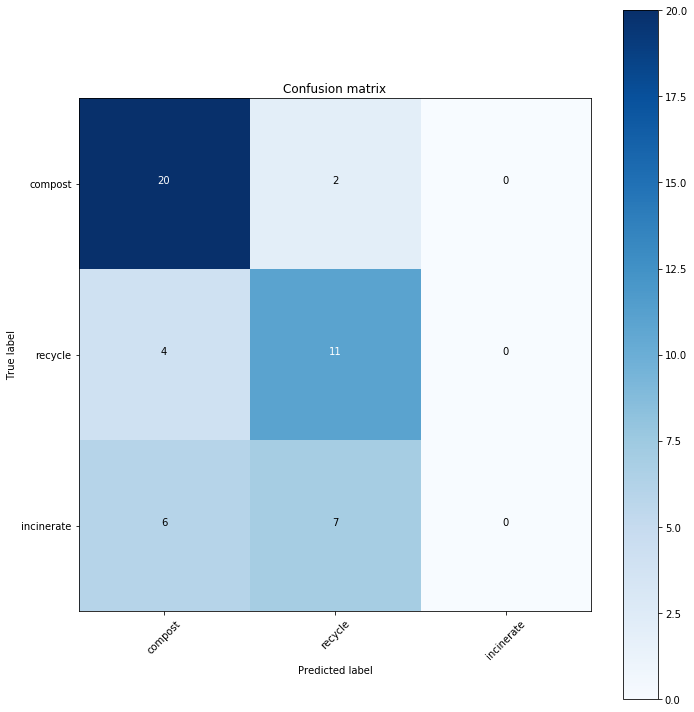

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truths.cpu(), preds.cpu())

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    print(plt.ylim())
    plt.ylim(2.5, -0.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ('compost', 'recycle', 'incinerate')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, class_names)